In [177]:
def subsample_average(x, width):

    """Downsamples x by averaging `width` points"""
    avg = np.nanmean(x.reshape(-1, width), axis=1)
    return avg


def moving_average(x,window_size):
    #moving average across data x within a window_size
    half_window_size=int(window_size/2)
    time_len=len(x)
    moving_average_trace=[]
    max_lim=(time_len-window_size/2)
    min_lim=half_window_size
    for i in range(time_len):
        if i >=min_lim and i <=max_lim :
            moving_average_trace.append(np.mean(x[i-half_window_size:i+half_window_size]))
        elif i<min_lim:
            moving_average_trace.append(np.mean(x[0:i+half_window_size]))
        elif i>max_lim:
            moving_average_trace.append(np.mean(x[i-half_window_size:time_len]))

    return np.asarray(moving_average_trace)

def get_yaml_config_params():
    #select yaml file and load all parameters
    #F = FileDialog()
    #fname = F.getOpenFileName(caption='Select a Config File')[0]
    fname_path = '/Users/stripathy/Documents/GitHub/valiante_lab_abf_process/config _sample2.yaml.txt'
    #load yaml params files
    with open(fname_path,'r') as f:
        params = yaml.load(f)
        
    return params

def plot_trace(imp,freq,moving_avg_wind,time,voltage,current,sharpness_thr,filtered_method,fig_idx,save_path):
    
    plt.figure(figsize=(20,20))
    plt.subplot(3, 1, 1)
    cen_freq,freq_3db,res_sharpness=plot_impedance_trace(imp,freq,moving_avg_wind,fig_idx,sharpness_thr,filtered_method)
    
    #plot voltage and current time trace
    plt.subplot(3, 1, 2)
    plt.plot(time, voltage*1e3)

    plt.ylabel('Voltage (mV)')
    
    plt.subplot(3, 1, 3)
    plt.plot(time, current*1e12)
    plt.xlabel('time (s)')
    plt.ylabel('Current(pA)')

    plt.savefig(save_path+str(fig_idx)+'.png')
    plt.close()
    
    
    return cen_freq,freq_3db,res_sharpness
    
    
    
def plot_impedance_trace(imp,freq,moving_avg_wind,fig_idx,sharpness_thr,filtered_method):
    #generate impedance trace over frequency with peak and cutoff frequency detection
    imp=imp/1e6
    plt.plot(freq,imp)
    
    prominence_factor=1.01
    if filtered_method==1:
       filtered_imp=moving_average(imp,moving_avg_wind)
    elif filtered_method==2:
       start_idx=np.argmin(freq-0.5)
       freq=freq[start_idx:]
       imp=imp[start_idx:]
       filtered_imp=moving_average(imp,moving_avg_wind)

#    filtered_imp = savgol_filter(imp, moving_avg_wind, 1)
    plt.plot(freq,filtered_imp)
    plt.ylim([np.min(imp)*0.9,np.max(imp)*1.1])
    idx_max_mag=np.argmax(filtered_imp)
    cen_freq=freq[idx_max_mag]

    
    left_imp_mean=np.median(filtered_imp[0:idx_max_mag-1])
    right_imp_mean=np.median(filtered_imp[idx_max_mag+1:])
    max_imp=filtered_imp[idx_max_mag]
    
    if (left_imp_mean*prominence_factor)>max_imp  or  (right_imp_mean*prominence_factor)>max_imp or cen_freq<0.5 :
        cen_freq=0  
        
    if cen_freq>0:
        res_sharpness=max_imp/filtered_imp[np.argmin(freq-0.5)]
    else:
        res_sharpness=0
        
    if sharpness_thr>res_sharpness:
        cen_freq=0  
    #find cutoff freq(3dB below max)
    i_3db_cutoff=np.argmin(abs(filtered_imp-max_imp/np.sqrt(2)))
    freq_3db=freq[i_3db_cutoff]
#     if cen_freq>0:
#         i_3db_cutoff=np.argmin(abs(filtered_imp-max_imp/np.sqrt(2)))
#         freq_3db=freq[i_3db_cutoff]
#     else:
#         freq_3db=0
        
        
    plt.xlabel('Frequency[Hz]')
    plt.ylabel('Impedance[MOhms]')
    if cen_freq is not None:
        if freq_3db is not None:
            plt.title('Trial {fig_idx}, '.format(fig_idx=fig_idx)+'Fr={:.2f} Hz, Cutoff Freq={:.2f}Hz, Sharpness={:.2f}'.format(cen_freq,freq_3db,res_sharpness))
        else:
            plt.title('Trial {fig_idx}, '.format(fig_idx=fig_idx)+'Fr={:.2f} Hz, Cutoff Freq=None'.format(cen_freq))
    else:
        plt.title('Trial {fig_idx}, No Resonance')
    plt.legend(['Raw Trace','Moving Averaged'])
    
    
    return cen_freq,freq_3db,res_sharpness

     
def cal_imp(abf,sweep_end_freq):
    ref_freq=np.linspace(0.1,sweep_end_freq,1000)
    recorded_var=abf.data
    dataRate=abf.dataRate
    total_time=np.arange(0,recorded_var.shape[1])/dataRate
    n_sample=10000
    adcUnits=abf.adcUnits
    #find the corresponding index for voltage and current in data
    current_idx=1
    voltage_idx=0
    for unit_idx,unit in enumerate(adcUnits):
        if unit=='pA':
            current_idx=unit_idx
        elif unit=='mV':
            voltage_idx=unit_idx
#    hamming_window=np.hamming(len(time))
#    hamming_window=gaussian(len(time), std=len(time)/2)
    #count the number of data sets in one folder and segment data accordingly
    sweepList=abf.sweepList 
    sweepTimesSec=np.asarray(sweepList)*abf.sweepLengthSec
    voltage_array=[]
    current_array=[]
    time_array=[]
    impedance_array=[]
    for sweep_idx in sweepList: 

        start_idx=int(sweepTimesSec[sweep_idx]*dataRate)
        if sweep_idx==sweepList[-1]:
            end_idx=len(total_time)-1
        else:
            end_idx=int(sweepTimesSec[sweep_idx+1]*dataRate)-1
            
            
        voltage=recorded_var[voltage_idx,start_idx:end_idx]*1e-3
        N=voltage.shape[0]
        width = int(N / n_sample)
        pad = int(width*np.ceil(N/width) - N)
        
        
        voltage_detrend=subsample_average(np.pad(voltage, (pad,0), 'constant', constant_values=np.nan), width)
        current=recorded_var[current_idx,start_idx:end_idx]*1e-12
        current_detrend=subsample_average(np.pad(current, (pad,0), 'constant', constant_values=np.nan), width)
        voltage_array.append(voltage_detrend)
        current_array.append(current_detrend)
        time=total_time[start_idx:end_idx]-total_time[start_idx]
        time=time[::width]
        time_array.append(time)
        #FFT on voltage and current
        sp_V= np.fft.fft(voltage_detrend)
        
        
        sp_I= np.fft.fft(current_detrend)
        freq = np.fft.fftfreq(len(time), d=time[1])
        half_freq=int(len(time)/2)
        
        #discard frequency above 20Hz and negative frequency
        freq=freq[1:half_freq]
        sp_V=sp_V[1:half_freq]
        sp_I=sp_I[1:half_freq]
        selected_freq=freq<21
        impedance=np.abs(sp_V[selected_freq]/sp_I[selected_freq])
        
        f_v=interp1d(freq[selected_freq],sp_V[selected_freq])
        f_i=interp1d(freq[selected_freq],sp_I[selected_freq])
        f_imp=interp1d(freq[selected_freq],impedance,fill_value="extrapolate")
        interpolated_trace=f_imp(ref_freq)
        impedance_array.append(interpolated_trace)
#        plt.figure()
#        plt.plot(time,recorded_var[voltage_idx,start_idx:end_idx])
        

    return impedance_array,ref_freq,voltage_array,current_array,time_array



In [178]:
import yaml
def get_yaml_config_params():
    #select yaml file and load all parameters
    #F = FileDialog()
    #fname = F.getOpenFileName(caption='Select a Config File')[0]
    fname_path = '/Users/stripathy/Documents/GitHub/valiante_lab_abf_process/config _sample2.yaml.txt'
    #load yaml params files
    with open(fname_path,'r') as f:
        params = yaml.load(f)
        
    return params

In [179]:
get_yaml_config_params()

{'data_file_path': '/Users/stripathy/Downloads/Analayzed/Sub threshold hold RMP-L23-Lihua',
 'root_result_folder': 'result',
 'sweep_end_freq': 20,
 'moving_avg_wind': 41,
 'is_resonance_filter': False,
 'sharpness_thr': 0,
 'filtered_method': 1}

In [180]:
import glob

# new_path = '/Users/stripathy/Downloads/Analayzed/'
# curr_zap_abf_files = glob.glob(new_path + '**/*.abf', recursive= True)

dir_list_regex = '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub*/'
dir_list = glob.glob(dir_list_regex, recursive= False)

dir_list_regex = '/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub*/'
temp_list = glob.glob(dir_list_regex, recursive= False)

dir_list = dir_list + temp_list

In [181]:
import matplotlib.pyplot as plt
import pyabf
import numpy as np
# from pyqtgraph import FileDialog
import os
from scipy.interpolate import interp1d
from scipy.signal import gaussian 
import yaml
import pandas as  pd
from scipy.signal import savgol_filter

#place all abf files in a directory, specify the path in the yaml config file
params=get_yaml_config_params()
data_file_path=params['data_file_path']

#data_file_path = '/Users/stripathy/Downloads/homeira_lihua_resonance_abf_files/Homeira/Layer 2 and 3 ZAP function Raw data/Subthreshold/Sub threshold hold RMP'
sweep_end_freq=params['sweep_end_freq']
moving_avg_wind=params['moving_avg_wind']
root_result_folder=params['root_result_folder']
is_sharpness_filter=params['is_resonance_filter']
sharpness_thr=params['sharpness_thr']
filtered_method=params['filtered_method']

if not(is_sharpness_filter):
    is_sharpness_filter=0
    
# rewrite folder findy thingy to look for abf files at leaf directories
    
folder_list=[]
for curr_dir in dir_list:
    
    data_file_path = curr_dir
    print(data_file_path)

    root_result_path=os.path.join(data_file_path,root_result_folder)
    #generating directory to save results
    if not(os.path.exists(root_result_path)):
        os.mkdir(root_result_path)


    root_result_path=os.path.join(data_file_path,root_result_folder)
    #generating directory to save results
    if not(os.path.exists(root_result_path)):
        os.mkdir(root_result_path)
    root_imped_fig_path=os.path.join(root_result_path,'impedance_fig')
    if not(os.path.exists(root_imped_fig_path)):
        os.mkdir(root_imped_fig_path)


    for curr_path, curr_dirs, curr_files in os.walk(data_file_path):
        for f in curr_files:
            if f.endswith('.abf'):
                folder_list.append(curr_path)
                print(curr_path)
                break
                #file_path = path + '/' + f
                #print(file_path)
                #os.remove(file_path)
        #print(folder_name)
#         path=os.path.join(data_file_path,folder_name)
#         print(path)
#         if os.path.isdir(path):
#             folder_list.append(path)
#             files = os.listdir(path)
#             for f in files:
#                 if f.endswith('.png'):
#                     file_path = path + '/' + f
#                     print(file_path)
#                     os.remove(file_path)

#     for idx_folder,folder_name in enumerate(os.listdir(data_file_path)):
#         print(folder_name)
#         path=os.path.join(data_file_path,folder_name)
#         print(path)
#         if os.path.isdir(path):
#             folder_list.append(path)
#             files = os.listdir(path)
#             for f in files:
#                 if f.endswith('.png'):
#                     file_path = path + '/' + f
#                     print(file_path)
#                     os.remove(file_path)
        
folder_list
        


/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/9
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/7
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/6
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/1
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/8
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/4
/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/3
/Users/stripathy/Downloads/homeira_lihua_

/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/23
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/4
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/15
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/3
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/12
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/13
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/5
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/14
/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayze

['/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/9',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/7',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/6',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/1',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/8',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/4',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/3',
 '/Users/stripathy/Downloads/homeira_lihua_zap_files/Lihua/Analayzed-Lihua-Zap data/Sub threshold hold -80 mV-L23-Lihua/2',
 '/Users

In [182]:
# load the sheets containing gains and offsets provided by homeira
# this is needed because we need to know what the RMP values are per cell

summary_table_csv = '/Users/stripathy/rstudio_projects/valiante_ih/summary_tables/gain_offset_info_merged.csv'
#excel_file = file_base_base_path + 'valiante_lab_ephys_mar_2020/L23/Homeira/Total2Homeira-Lastversion_March 10_2020.xlsx'
cell_info = pd.read_csv(open(summary_table_csv, 'rb'))  

In [183]:

abf_path = '/Users/stripathy/Downloads/homeira_lihua_zap_files/Analayzed-Homeira-Zap data 3/Sub threshold hold RMP-L5- Homeira/20/2020_01_27_0000.abf'
abf = pyabf.ABF(abf_path)

impedance_array,ref_freq,voltage_array,current_array,time_array=cal_imp(abf,sweep_end_freq)

from ipfx.feature_extractor import SpikeFeatureExtractor

ext = SpikeFeatureExtractor(start = .1, end = 1, filter = .5)

spike_detect_threshold = -20
spiking_sweeps = [any(array > spike_detect_threshold * .001) for array in voltage_array]
print(spiking_sweeps)
    
#results = ext.process(t=time_array[0], v=voltage_array[0], i=current_array[0])


[True, True, False]


In [397]:
filtered_method

1

In [184]:
from pathlib import Path

impedance_file_array=[]
#storing data from different files in a list
v_file_array=[]
i_file_array=[]

max_file_num_for_analysis = 10
max_sweep_count_per_file = 20
spike_detect_threshold = 0

max_sweeps_for_average = 5
#reference freq for interpolation(data length consistency)

index=['trial','center_freq','3dB_freq' ,'res_sharpness', 'abf_name', 'cell_ID', 'file_time']
df_array=[]
failing_file_vec = []
datacount=0
dict_list = dict()
for folder_path in folder_list:
    
    file_list= glob.glob(folder_path + "/*.abf")
    if len(file_list) == 0:
        continue
    
    if file_list[0].endswith('.abf'):
        folder_name=folder_path.split('/')[-1]
        df = pd.DataFrame(columns=index)
        impedance_all=[]
        voltage_all = []
        current_all = []
        time_all = []
        
        for idx_file,file_name in enumerate(os.listdir(folder_path)):
            if file_name.endswith(".abf") and idx_file < max_file_num_for_analysis:
                fname=os.path.join(folder_path, file_name)
                dir_info=fname.split('/')
                #cell_ID = '1'
                cell_ID=dir_info[-2]
                abf_name=dir_info[-1].split('.')[0]
                
                if not(cell_ID==abf_name):
                    print('Processing: '+abf_name + ' from cell ' + cell_ID)
                    print(file_name)
                    abf = pyabf.ABF(fname)
                    file_time = abf.abfDateTime
                    is_intrinsic = any(cell_info['cell_id'].isin([file_name]))
                    if abf.sweepCount > max_sweep_count_per_file or is_intrinsic:
                        print('skipping file, %d too many sweeps' % abf.sweepCount)
                        print('or is %s is intrinsic file' % file_name)
                        continue
                    try: 
                        
                        impedance_array,ref_freq,voltage_array,current_array,time_array=cal_imp(abf,sweep_end_freq)
                        spiking_sweeps = [any(array > spike_detect_threshold * .001) for array in voltage_array]
                                               
                        
                        impedance_all.append(np.asarray(impedance_array))
                        voltage_all.append(np.asarray(voltage_array))
                        current_all.append(np.asarray(current_array))
                        time_all.append(np.asarray(time_array))
                    
                    except Exception:
                        print('failing file: ' + file_name)
                        failing_file_vec.append(file_name)
                        continue
                    
                    for trial_idx,impedance in enumerate(impedance_array):
                        
                        # check if sweep has spikes
                        has_spike = any(voltage_array[trial_idx] > spike_detect_threshold * .001)
                        
                        try:
                            imped_fig_path=os.path.join(root_imped_fig_path,cell_ID)
                            if not(os.path.exists(imped_fig_path)):
                                os.mkdir(imped_fig_path)
                            cen_freq,freq_3db,res_sharpness=plot_trace(impedance,ref_freq,moving_avg_wind,
                                                                       time_array[trial_idx],voltage_array[trial_idx],
                                                                       current_array[trial_idx],sharpness_thr,
                                                                       filtered_method,
                                                                       trial_idx,
                                                                       os.path.join(imped_fig_path,abf_name))
                        except Exception:
                            print('failing file: ' + file_name)
                            failing_file_vec.append(file_name)
                            continue
                        
                        
                        df=df.append({'trial':trial_idx,'center_freq':cen_freq,
                                      '3dB_freq':freq_3db,'res_sharpness':res_sharpness,
                                     'abf_name': file_name, 'cell_ID': cell_ID, 
                                     'file_time': file_time, 'has_spike':has_spike},ignore_index=True)
        if len(impedance_all)==0 or len(df) == 0:
            continue
        
        # reorder by abf file start time
        df = df.sort_values(by=['file_time', 'trial'])
        
        #avg_df = df
        avg_df = df.query('has_spike == 0')
        
        index_values = avg_df.index.to_numpy()
        avg_df = avg_df.reset_index(drop = True)
        if avg_df.shape[0] == 0:
            continue
        first_abf_file_name = avg_df.iloc[0]['abf_name']
        
        try:
            voltage_all = np.concatenate(voltage_all)
            current_all = np.concatenate(current_all)
            time_all = np.concatenate(time_all)
        except Exception:
            print('different stimulus type error')
            print('failing file: ' + file_name)
            failing_file_vec.append(file_name)
            continue
        impedance_all = np.concatenate(impedance_all)
        
#         spiking_sweeps = ![any(array > spike_detect_threshold * .001) for array in voltage_all]
#         keep_sweeps = np.logical_not(spiking_sweeps)
        
#         voltage_all = voltage_all[keep_sweeps]
#         current_all = current_all[keep_sweeps]
#         impedance_all = impedance_all[keep_sweeps]
#         time_all = time_all[keep_sweeps]
        
        max_sweeps_for_average = 3
        impedance_all = impedance_all[index_values[0:max_sweeps_for_average],: ]
        voltage_all = voltage_all[index_values[0:max_sweeps_for_average],: ]
        current_all = current_all[index_values[0:max_sweeps_for_average],: ]
        time_all = time_all[index_values[0:max_sweeps_for_average],: ]
        
        #impedance_all=np.concatenate(impedance_all)
        impedance_mean=np.median(impedance_all,axis=0)
        voltage_mean=np.median(voltage_all,axis=0)
        current_mean = np.median(current_all,axis=0)
        
        cen_freq,freq_3db,res_sharpness=plot_trace(impedance_mean,ref_freq,moving_avg_wind,time_array[0],voltage_mean, current_mean,sharpness_thr,filtered_method,-1,os.path.join(imped_fig_path,'avg'))
        
        df=df.append({'trial':'avg','center_freq':cen_freq,
                      '3dB_freq':freq_3db,'res_sharpness':res_sharpness, 
                      'abf_name': first_abf_file_name, 'cell_ID': cell_ID, 
                     'file_time': file_time, 'has_spike':False},ignore_index=True)
        df.set_index('trial')

        df_array.append(df)
        
        avg_res_dict = {'impedance_mean':impedance_mean, 'ref_freq':ref_freq, 
                     'voltage_mean':voltage_mean, 'current_mean':current_mean, 'time_array':time_array[0]}
        dict_list[first_abf_file_name] = avg_res_dict

Processing: 15312099 from cell 9
15312099.abf
Processing: 15312098 from cell 9
15312098.abf
Processing: 15312102 from cell 9
15312102.abf
Processing: 15312100 from cell 9
15312100.abf
Processing: 15312101 from cell 9
15312101.abf
Processing: 15312093 from cell 9
15312093.abf
Processing: 15312095 from cell 9
15312095.abf
Processing: 15312094 from cell 9
15312094.abf
Processing: 15312096 from cell 9
15312096.abf
Processing: 15312097 from cell 9
15312097.abf
Processing: 15127128 from cell 7
15127128.abf
Processing: 15127129 from cell 7
15127129.abf
Processing: 15127127 from cell 7
15127127.abf
Processing: 15127126 from cell 7
15127126.abf
Processing: 15127130 from cell 7
15127130.abf
Processing: 15127124 from cell 7
15127124.abf
Processing: 15127125 from cell 7
15127125.abf
Processing: 15127121 from cell 7
15127121.abf
Processing: 15127120 from cell 7
15127120.abf
Processing: 15127122 from cell 7
15127122.abf
Processing: 15127075 from cell 6
15127075.abf
Processing: 15127077 from cell 6
1

/Users/stripathy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/stripathy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing: 14317350 from cell 3
14317350.abf
Processing: 14317349 from cell 3
14317349.abf
Processing: 14306310 from cell 2
14306310.abf
Processing: 14306307 from cell 2
14306307.abf
Processing: 14306300 from cell 2
14306300.abf
skipping file, 30 too many sweeps
or is 14306300.abf is intrinsic file
Processing: 14306309 from cell 2
14306309.abf
Processing: 14306308 from cell 2
14306308.abf
Processing: 14d02119 from cell 5
14d02119.abf
Processing: 14d02118 from cell 5
14d02118.abf
Processing: 14d02109 from cell 5
14d02109.abf
Processing: 14d02110 from cell 5
14d02110.abf
Processing: 14d02111 from cell 5
14d02111.abf
Processing: 14d02113 from cell 5
14d02113.abf
Processing: 14d02112 from cell 5
14d02112.abf
Processing: 14d02116 from cell 5
14d02116.abf
Processing: 14d02117 from cell 5
14d02117.abf
Processing: 14d02115 from cell 5
14d02115.abf
Processing: 15420105 from cell 20
15420105.abf
Processing: 15420104 from cell 20
15420104.abf
Processing: 15420099 from cell 20
15420099.abf
Proces

Processing: 14918348 from cell 13
14918348.abf
Processing: 14918349 from cell 13
14918349.abf
Processing: 14918350 from cell 13
14918350.abf
Processing: 14918351 from cell 13
14918351.abf
Processing: 14918347 from cell 13
14918347.abf
Processing: 14918353 from cell 13
14918353.abf
Processing: 14918352 from cell 13
14918352.abf
Processing: 14918356 from cell 13
14918356.abf
Processing: 14918355 from cell 13
14918355.abf
Processing: 14918354 from cell 13
14918354.abf
Processing: 14605301 from cell 5
14605301.abf
Processing: 14605302 from cell 5
14605302.abf
Processing: 14605303 from cell 5
14605303.abf
Processing: 14605307 from cell 5
14605307.abf
Processing: 14605312 from cell 5
14605312.abf
Processing: 14605306 from cell 5
14605306.abf
Processing: 14605310 from cell 5
14605310.abf
Processing: 14605304 from cell 5
14605304.abf
Processing: 14605305 from cell 5
14605305.abf
Processing: 14605311 from cell 5
14605311.abf
Processing: 14918371 from cell 14
14918371.abf
skipping file, 30 too m

Processing: 14d18117 from cell 16
14d18117.abf
Processing: 14317323 from cell 6
14317323.abf
Processing: 14317322 from cell 6
14317322.abf
Processing: 14317321 from cell 6
14317321.abf
Processing: 14317325 from cell 6
14317325.abf
Processing: 14317324 from cell 6
14317324.abf
Processing: 15105012 from cell 17
15105012.abf
Processing: 15105006 from cell 17
15105006.abf
Processing: 15105007 from cell 17
15105007.abf
Processing: 15105013 from cell 17
15105013.abf
Processing: 15105005 from cell 17
15105005.abf
Processing: 15105011 from cell 17
15105011.abf
Processing: 15105010 from cell 17
15105010.abf
Processing: 15105004 from cell 17
15105004.abf
Processing: 15105014 from cell 17
15105014.abf
Processing: 15105009 from cell 17
15105009.abf
Processing: 14224312 from cell 1
14224312.abf
Processing: 14224306 from cell 1
14224306.abf
Processing: 14224307 from cell 1
14224307.abf
Processing: 14224305 from cell 1
14224305.abf
Processing: 14224311 from cell 1
14224311.abf
Processing: 14224310 fr

Processing: 2020_01_06_0008 from cell 7
2020_01_06_0008.abf
Processing: 2020_01_06_0009 from cell 7
2020_01_06_0009.abf
Processing: 2020_01_06_0014 from cell 7
2020_01_06_0014.abf
Processing: 2020_01_06_0010 from cell 7
2020_01_06_0010.abf
Processing: 2020_01_06_0011 from cell 7
2020_01_06_0011.abf
Processing: 2020_01_06_0013 from cell 7
2020_01_06_0013.abf
Processing: 2020_01_06_0007 from cell 7
2020_01_06_0007.abf
Processing: 2020_01_06_0012 from cell 7
2020_01_06_0012.abf
Processing: 2020_01_06_0097 from cell 16
2020_01_06_0097.abf
Processing: 2020_01_06_0098 from cell 16
2020_01_06_0098.abf
Processing: 2019_11_28_0006 from cell 2019_11_28_0010
2019_11_28_0006.abf
Processing: 2019_11_28_0005 from cell 2019_11_28_0010
2019_11_28_0005.abf
Processing: 2019_11_28_0004 from cell 2019_11_28_0010
2019_11_28_0004.abf
Processing: 2019_11_28_0003 from cell 2019_11_28_0010
2019_11_28_0003.abf
Processing: 2019_11_28_0002 from cell 2019_11_28_0010
2019_11_28_0002.abf
Processing: 2020_01_27_0043 

Processing: 2016_02_25_0220 from cell 2016_02_25_0255
2016_02_25_0220.abf
Processing: 2016_02_25_0222 from cell 2016_02_25_0255
2016_02_25_0222.abf
Processing: 2016_02_25_0077 from cell 2016_02_25_0073
2016_02_25_0077.abf
Processing: 2016_02_25_0079 from cell 2016_02_25_0073
2016_02_25_0079.abf
Processing: 2016_02_25_0078 from cell 2016_02_25_0073
2016_02_25_0078.abf
Processing: 2016_03_03_0029 from cell 2016_03_03_0002
2016_03_03_0029.abf
Processing: 2016_03_03_0028 from cell 2016_03_03_0002
2016_03_03_0028.abf
Processing: 2016_03_03_0034 from cell 2016_03_03_0002
2016_03_03_0034.abf
Processing: 2016_03_03_0035 from cell 2016_03_03_0002
2016_03_03_0035.abf
Processing: 2016_03_03_0037 from cell 2016_03_03_0002
2016_03_03_0037.abf
Processing: 2016_03_03_0036 from cell 2016_03_03_0002
2016_03_03_0036.abf
Processing: 2016_03_03_0032 from cell 2016_03_03_0002
2016_03_03_0032.abf
Processing: 2016_03_03_0033 from cell 2016_03_03_0002
2016_03_03_0033.abf
Processing: 2016_03_03_0031 from cell 

Processing: 2016_02_25_0088 from cell 2016_02_25_0082
2016_02_25_0088.abf
Processing: 2016_02_25_0103 from cell 2016_02_25_0082
2016_02_25_0103.abf
Processing: 2016_02_25_0107 from cell 2016_02_25_0082
2016_02_25_0107.abf
Processing: 2016_02_25_0098 from cell 2016_02_25_0082
2016_02_25_0098.abf
Processing: 2016_02_25_0099 from cell 2016_02_25_0082
2016_02_25_0099.abf
Processing: 2016_02_25_0106 from cell 2016_02_25_0082
2016_02_25_0106.abf
Processing: 2016_03_03_0062 from cell 2016_03_03_0054
2016_03_03_0062.abf
Processing: 2016_03_03_0063 from cell 2016_03_03_0054
2016_03_03_0063.abf
Processing: 2016_03_03_0061 from cell 2016_03_03_0054
2016_03_03_0061.abf
Processing: 2016_03_03_0060 from cell 2016_03_03_0054
2016_03_03_0060.abf
Processing: 2016_03_03_0058 from cell 2016_03_03_0054
2016_03_03_0058.abf
Processing: 2016_03_03_0064 from cell 2016_03_03_0054
2016_03_03_0064.abf
Processing: 2016_03_03_0065 from cell 2016_03_03_0054
2016_03_03_0065.abf
Processing: 2016_03_03_0059 from cell 

Processing: 2016_02_25_0235 from cell 2016_02_25_0255
2016_02_25_0235.abf
Processing: 2016_02_25_0234 from cell 2016_02_25_0255
2016_02_25_0234.abf
Processing: 2016_02_25_0236 from cell 2016_02_25_0255
2016_02_25_0236.abf
Processing: 2016_03_01_0132 from cell 6
2016_03_01_0132.abf
Processing: 2016_03_01_0133 from cell 6
2016_03_01_0133.abf
Processing: 2016_03_01_0131 from cell 6
2016_03_01_0131.abf
Processing: 2016_03_01_0130 from cell 6
2016_03_01_0130.abf
Processing: 2016_03_01_0134 from cell 6
2016_03_01_0134.abf
Processing: 2016_03_01_0135 from cell 6
2016_03_01_0135.abf
Processing: 2016_03_01_0137 from cell 6
2016_03_01_0137.abf
Processing: 2016_03_01_0136 from cell 6
2016_03_01_0136.abf
Processing: 2016_03_01_0138 from cell 6
2016_03_01_0138.abf
Processing: 2016_03_01_0129 from cell 6
2016_03_01_0129.abf
Processing: 2016_03_01_0085 from cell 2016_03_01_0047
2016_03_01_0085.abf
Processing: 2016_03_01_0084 from cell 2016_03_01_0047
2016_03_01_0084.abf
Processing: 2016_03_01_0086 fr

Processing: 17032014_0196 from cell 6
17032014_0196.abf
Processing: 17032014_0192 from cell 6
17032014_0192.abf
Processing: 17032014_0193 from cell 6
17032014_0193.abf
Processing: 17032014_0191 from cell 6
17032014_0191.abf
Processing: 17032014_0190 from cell 6
17032014_0190.abf
Processing: 19129006 from cell 28
19129006.abf
Processing: 19129009 from cell 28
19129009.abf
Processing: 19129008 from cell 28
19129008.abf
different stimulus type error
failing file: 19129008.abf
Processing: 2019_11_26_0096 from cell 17
2019_11_26_0096.abf
Processing: 2019_11_26_0097 from cell 17
2019_11_26_0097.abf
Processing: 2016_02_29_0013 from cell 1
2016_02_29_0013.abf
Processing: 2016_02_29_0007 from cell 1
2016_02_29_0007.abf
Processing: 2016_02_29_0006 from cell 1
2016_02_29_0006.abf
Processing: 2016_02_29_0012 from cell 1
2016_02_29_0012.abf
Processing: 2016_02_29_0010 from cell 1
2016_02_29_0010.abf
Processing: 2016_02_29_0011 from cell 1
2016_02_29_0011.abf
Processing: 2016_02_29_0005 from cell 1


In [192]:
df = pd.concat(df_array, ignore_index = True)
#df.sort_values(by=['file_time', 'trial'])

df




,trial,center_freq,3dB_freq,res_sharpness,abf_name,cell_ID,file_time,has_spike
0,0,0,6.394695,0,15312093.abf,9,2015-03-12 15:45:29.216,0.0
1,0,0,0.518318,0,15312094.abf,9,2015-03-12 15:45:54.278,0.0
2,0,0,1.195596,0,15312095.abf,9,2015-03-12 15:46:19.106,0.0
3,0,0,1.474474,0,15312096.abf,9,2015-03-12 15:46:44.575,0.0
4,0,0,1.733433,0,15312097.abf,9,2015-03-12 15:47:22.528,0.0
5,0,0,1.354955,0,15312098.abf,9,2015-03-12 15:47:54.324,0.0
6,0,0,1.593994,0,15312099.abf,9,2015-03-12 15:48:26.871,0.0
7,0,0,1.474474,0,15312100.abf,9,2015-03-12 15:49:28.527,0.0
8,0,0,1.514314,0,15312101.abf,9,2015-03-12 15:49:54.449,0.0
9,0,0,0.856957,0,15312102.abf,9,2015-03-12 15:51:05.073,0.0


In [193]:
df_avgs_only = df[df['trial'] == 'avg']
df_avgs_only

,trial,center_freq,3dB_freq,res_sharpness,abf_name,cell_ID,file_time,has_spike
10,avg,0,0.856957,0,15312093.abf,9,2015-03-12 15:47:22.528,0.0
21,avg,0,6.354855,0,15127120.abf,7,2015-01-27 19:46:37.773,0.0
32,avg,0,6.514214,0,15127075.abf,6,2015-01-27 17:28:23.546,0.0
37,avg,0,12.530030,0,14304312.abf,1,2014-03-04 17:13:21.004,0.0
48,avg,0,4.920621,0,15312067.abf,8,2015-03-12 15:22:46.559,0.0
59,avg,0,10.617718,0,14d02005.abf,4,2014-12-02 14:42:43.376,0.0
64,avg,0,10.298999,0,14317349.abf,3,2014-03-17 18:06:21.919,0.0
69,avg,0,19.621522,0,14306307.abf,2,2014-03-06 11:53:18.801,0.0
80,avg,0,1.295195,0,14d02109.abf,5,2014-12-02 17:11:53.005,0.0
91,avg,0,12.669469,0,15420098.abf,20,2015-04-20 16:39:22.467,0.0


In [195]:
df_avgs_only.to_csv('output_files/fred_zap_analysis.csv')

In [49]:
df_avgs_only.to_csv('output_files/fred_zap_analysis.csv')

In [13]:
dict_list

{'15312093.abf': {'impedance_mean': array([1.1898e+11, 1.6302e+11, 1.8531e+11, ..., 3.2750e+10, 3.2708e+10,
         3.2670e+10]),
  'ref_freq': array([ 0.1   ,  0.1199,  0.1398, ..., 19.9602, 19.9801, 20.    ]),
  'voltage_mean': array([-0.0811, -0.0811, -0.0812, ..., -0.081 , -0.0811, -0.0811],
        dtype=float32),
  'current_mean': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'time_array': array([ 0.    ,  0.0022,  0.0044, ..., 22.9944, 22.9966, 22.9988])},
 '15127120.abf': {'impedance_mean': array([9.9789e+10, 8.4493e+10, 7.5040e+10, ..., 3.7270e+10, 3.5838e+10,
         3.4515e+10]),
  'ref_freq': array([ 0.1   ,  0.1199,  0.1398, ..., 19.9602, 19.9801, 20.    ]),
  'voltage_mean': array([-0.0803, -0.0803, -0.0802, ..., -0.0803, -0.0803, -0.0803],
        dtype=float32),
  'current_mean': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'time_array': array([ 0.    ,  0.0022,  0.0044, ..., 22.9944, 22.9966, 22.9988])},
 '15127075.abf': {'impedance_mean': array([7

In [310]:
row = dict_list['14d16019.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
filtered_imp=moving_average(impedance_mean,101 )
idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

print(cen_freq)
[min(impedance_mean), max(impedance_mean)]

1.4545545545545546


[21750686115.138885, 41938515328.60087]

<Figure size 576x576 with 0 Axes>

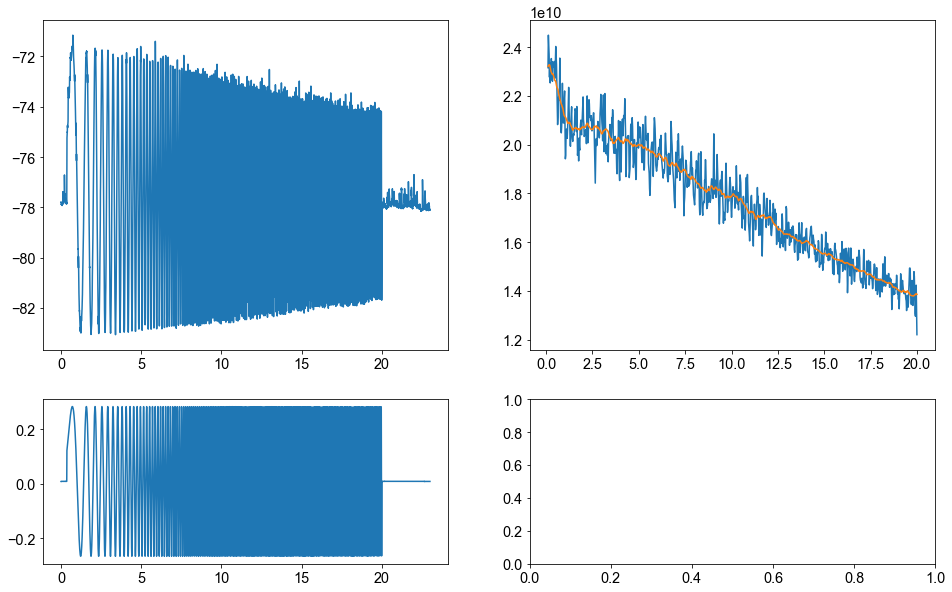

In [294]:
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = [16, 10]

fig = plt.figure(figsize=(8, 8))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[2, 1]})
ax1.plot(time_array, voltage_mean * 1000)
ax3.plot(time_array, current_mean * 1e12)
#ax2.plot([cen_freq, cen_freq], [min(impedance_mean), max(impedance_mean)])
ax2.plot(ref_freq, impedance_mean)
ax2.plot(ref_freq,filtered_imp)


In [ ]:
plot_list = '14317335.abf' # most resonant L2.3 cell
'19122003.abf' # small layer 2.3 cell

# L3c
'2020_03_02_0019.abf' # most resonant L3c cell
'2020_01_06_0048.abf' # weakly resonance, L3c cell

# L5
'15420000.abf' # most resonant L5 cell
'19129015.abf' # small L5 morphology, not resonant


<Figure size 576x576 with 0 Axes>

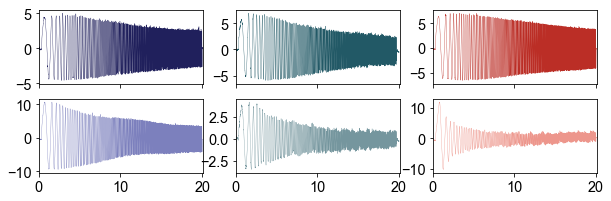

In [223]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}


pylab.rcParams.update(params)
pylab.rcParams['pdf.fonttype'] = 42
pylab.rcParams['ps.fonttype'] = 42

row = dict_list['14317335.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

plt.rcParams['figure.figsize'] = [10, 3]

fig = plt.figure(figsize=(8, 8))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,  sharey = False, sharex = True, gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios':[1, 1]})

ax1.plot(time_array, voltage_mean * 1000, '#20205C', linewidth=.33)

row = dict_list['19129006.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean * .25 * 1000 -19.7
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax4.plot(time_array, voltage_mean, "#7C80BD", linewidth=.33)

row = dict_list['2020_03_02_0017.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax2.plot(time_array, (voltage_mean *1000), "#225966", linewidth=.33)

row = dict_list['2020_01_06_0039.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax5.plot(time_array, (voltage_mean *1000), "#75969E", linewidth=.33)

row = dict_list['15420003.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax3.plot(time_array, (voltage_mean *1000), "#BB2E26", linewidth=.33)

row = dict_list['19129016.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = (voltage_mean * .25 * 1000) -22.7
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax6.plot(time_array, voltage_mean, "#ED968C", linewidth=.33)

ax1.axes.set_xlim(0, 20.1)
fig.savefig('figs/pretty_figs/zap_examples.pdf', format='pdf')


#ax1.yaxis.set_ticks(np.arange(0, 10, 2))



# ax3.plot(time_array, current_mean * 1e12)
# #ax2.plot([cen_freq, cen_freq], [min(impedance_mean), max(impedance_mean)])
# ax2.plot(ref_freq, impedance_mean)
# ax2.plot(ref_freq,filtered_imp)

<Figure size 576x576 with 0 Axes>

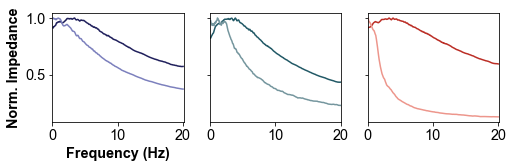

In [224]:
import matplotlib.pylab as pylab



row = dict_list['14317335.abf']

impedance_mean = row['impedance_mean'] / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

plt.rcParams['figure.figsize'] = [8, 2]

fig = plt.figure(figsize=(8, 8))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, sharex = True, gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios':[1]})

ax1.plot(ref_freq, filtered_imp, '#20205C', linewidth=1.5)

row = dict_list['19129006.abf']

impedance_mean = row['impedance_mean'] * .25 * 1000 / .2 / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean * .25 * 1000 -19.7
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax1.plot(ref_freq, filtered_imp, "#7C80BD", linewidth=1.5)

row = dict_list['2020_03_02_0017.abf']

impedance_mean = row['impedance_mean'] / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax2.plot(ref_freq, filtered_imp, "#225966", linewidth=1.5)

row = dict_list['2020_01_06_0039.abf']

impedance_mean = row['impedance_mean']  / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax2.plot(ref_freq, filtered_imp, "#75969E", linewidth=1.5)

row = dict_list['15420003.abf']

impedance_mean = row['impedance_mean'] / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax3.plot(ref_freq, filtered_imp, "#BB2E26", linewidth=1.5)

row = dict_list['19129016.abf']

impedance_mean = row['impedance_mean'] 
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = (voltage_mean * .25 * 1000) -22.7
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp = moving_average(impedance_mean,moving_avg_wind)
filtered_imp = filtered_imp / np.max(filtered_imp)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax3.plot(ref_freq, filtered_imp, "#ED968C", linewidth=1.5)

ax1.axes.set_xlim(0, 20.1)
ax1.set_ylabel('Norm. Impedance')
ax1.set_xlabel('Frequency (Hz)')

fig.savefig('figs/pretty_figs/norm_impedance.pdf', format='pdf')


<Figure size 576x576 with 0 Axes>

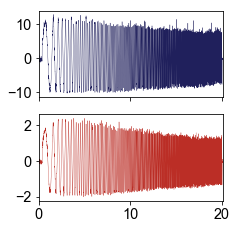

In [312]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}


pylab.rcParams.update(params)
pylab.rcParams['pdf.fonttype'] = 42
pylab.rcParams['ps.fonttype'] = 42

row = dict_list['14d16019.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

plt.rcParams['figure.figsize'] = [3.3, 3.5]

fig = plt.figure(figsize=(8, 8))
fig, ((ax1, ax2)) = plt.subplots(2, 1,  sharey = False, sharex = True )

ax1.plot(time_array, voltage_mean * 1000, '#20205C', linewidth=.33)

row = dict_list['14605301.abf']

impedance_mean = row['impedance_mean']
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean * .25 * 1000 -19.7
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,moving_avg_wind)

idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax2.plot(time_array, voltage_mean, "#BB2E26", linewidth=.33)

ax1.axes.set_xlim(0, 20.1)
fig.savefig('figs/pretty_figs/zap_int_examples.pdf', format='pdf')


#ax1.yaxis.set_ticks(np.arange(0, 10, 2))



# ax3.plot(time_array, current_mean * 1e12)
# #ax2.plot([cen_freq, cen_freq], [min(impedance_mean), max(impedance_mean)])
# ax2.plot(ref_freq, impedance_mean)
# ax2.plot(ref_freq,filtered_imp)

<Figure size 576x576 with 0 Axes>

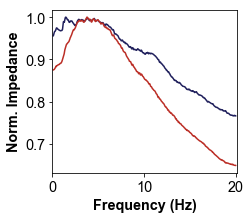

In [313]:
import matplotlib.pylab as pylab



row = dict_list['14d16019.abf']

impedance_mean = row['impedance_mean'] / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,101)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

plt.rcParams['figure.figsize'] = [3.3, 3]

fig = plt.figure(figsize=(8, 8))
fig, (ax1) = plt.subplots(1, 1, sharey = True, sharex = True)

ax1.plot(ref_freq, filtered_imp, '#20205C', linewidth=1.5)

row = dict_list['14605301.abf']

impedance_mean = row['impedance_mean'] * .25 * 1000 / .2 / 1E9
ref_freq = row['ref_freq']
time_array = row['time_array']
current_mean = row['current_mean']
voltage_mean = row['voltage_mean']
voltage_mean = voltage_mean * .25 * 1000 -19.7
voltage_mean = voltage_mean - np.mean(voltage_mean)

filtered_imp=moving_average(impedance_mean,101)
filtered_imp = filtered_imp / np.max(filtered_imp)


idx_max_mag=np.argmax(filtered_imp)
cen_freq=ref_freq[idx_max_mag]

ax1.plot(ref_freq, filtered_imp, "#BB2E26", linewidth=1.5)


ax1.axes.set_xlim(0, 20.1)
ax1.set_ylabel('Norm. Impedance')
ax1.set_xlabel('Frequency (Hz)')

fig.savefig('figs/pretty_figs/int_norm_impedance.pdf', format='pdf')


30


<Figure size 576x360 with 0 Axes>

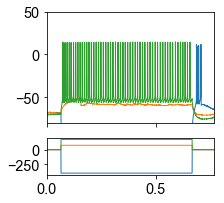

In [400]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

from scripts.util_functions import guess_response_gain, get_stim_gain, get_stim_info, get_stim_dict
# read final csv that has the ouput of metadata gathering process
csv_meta_save_path = 'output_files/cell_final_raw_meta_df.csv'
cell_final_raw_meta_df = pd.read_csv(open(csv_meta_save_path, 'rb'))  

#from scripts.abf_plotting import plot_ephys_from_abf
from scripts.abf_to_sweep_set import cell_id_to_sweep_set
from scripts.abf_feature_extraction import get_baseball_card_fig, get_lsa_results

abf_file_name = "14605300.abf"
#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]
num_sweeps = int(meta_row['num_sweeps'].values[0])
print(num_sweeps)
use_sweeps = [0, num_sweeps - 11, num_sweeps - 7]


plt.rcParams['figure.figsize'] = [3, 3]

plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/layer5_int_voltage.pdf', format='pdf')


30


<Figure size 576x360 with 0 Axes>

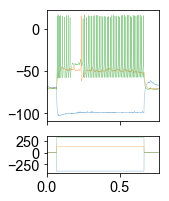

In [352]:

abf_file_name = "14d16016.abf"
#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]
num_sweeps = int(meta_row['num_sweeps'].values[0])
print(num_sweeps)
use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]


plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/layer23_int_voltage.pdf', format='pdf')


30


<Figure size 576x360 with 0 Axes>

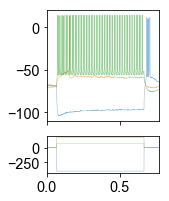

In [353]:

abf_file_name = "14605300.abf"
#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]
num_sweeps = int(meta_row['num_sweeps'].values[0])
print(num_sweeps)
use_sweeps = [0, num_sweeps - 11, num_sweeps - 7]


plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/layer5_int_voltage.pdf', format='pdf')


17
30
17


<Figure size 576x360 with 0 Axes>

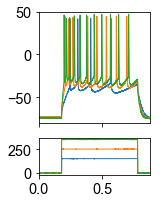

<Figure size 576x360 with 0 Axes>

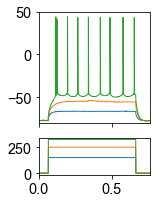

<Figure size 576x360 with 0 Axes>

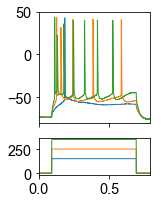

In [396]:
# abf_file_name = "2019_11_26_0110.abf"

abf_file_name = "19320017.abf"
use_sweeps = [num_sweeps - 6, num_sweeps - 4, num_sweeps - 2]

#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

num_sweeps = int(meta_row['num_sweeps'].values[0])
use_sweeps = [num_sweeps - 6, num_sweeps - 4, num_sweeps - 2]

print(num_sweeps)

plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/layer23_pyr_voltage.pdf', format='pdf')

# abf_file_name = "2019_11_26_0110.abf"

abf_file_name = "15420096.abf"

#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

num_sweeps = int(meta_row['num_sweeps'].values[0])
use_sweeps = [num_sweeps - 8, num_sweeps - 4, num_sweeps -1]

print(num_sweeps)

plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/layer5_pyr_voltage.pdf', format='pdf')

abf_file_name = "2020_01_06_0082.abf"
use_sweeps = [num_sweeps - 6, num_sweeps - 4, num_sweeps - 2]

#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

num_sweeps = int(meta_row['num_sweeps'].values[0])
use_sweeps = [num_sweeps - 6, num_sweeps - 4, num_sweeps - 2]

print(num_sweeps)

plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/layer3c_pyr_voltage.pdf', format='pdf')


13
17


<Figure size 576x360 with 0 Axes>

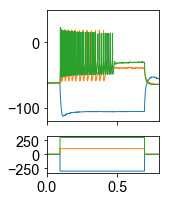

<Figure size 576x360 with 0 Axes>

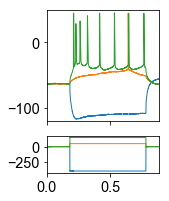

In [417]:
# abf_file_name = "2019_11_26_0110.abf"

abf_file_name = "2019_11_28_0119.abf"
#use_sweeps = [0, num_sweeps - 4, num_sweeps - 2]

#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

num_sweeps = int(meta_row['num_sweeps'].values[0])
use_sweeps = [0, num_sweeps - 5, num_sweeps - 1]

print(num_sweeps)

plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/bipolar_cell_voltage.pdf', format='pdf')

abf_file_name = "19129015.abf"


#use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

num_sweeps = int(meta_row['num_sweeps'].values[0])
use_sweeps = [0, num_sweeps - 8, num_sweeps - 6]

print(num_sweeps)

plt.rcParams['figure.figsize'] = [2, 3]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
fig.savefig('figs/pretty_figs/l5_cell_small_voltage.pdf', format='pdf')

# abf_file_name = "15420096.abf"

# #use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
# meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

# num_sweeps = int(meta_row['num_sweeps'].values[0])
# use_sweeps = [num_sweeps - 8, num_sweeps - 4, num_sweeps -1]

# print(num_sweeps)

# plt.rcParams['figure.figsize'] = [2, 3]

# (fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
# fig.savefig('figs/pretty_figs/layer5_pyr_voltage.pdf', format='pdf')

# abf_file_name = "2020_01_06_0082.abf"
# use_sweeps = [num_sweeps - 6, num_sweeps - 4, num_sweeps - 2]

# #use_sweeps = [0, num_sweeps - 9, num_sweeps - 1]
# meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]

# num_sweeps = int(meta_row['num_sweeps'].values[0])
# use_sweeps = [num_sweeps - 6, num_sweeps - 4, num_sweeps - 2]

# print(num_sweeps)

# plt.rcParams['figure.figsize'] = [2, 3]

# (fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = use_sweeps)
# fig.savefig('figs/pretty_figs/layer3c_pyr_voltage.pdf', format='pdf')


In [413]:
from ipfx.sweep import Sweep, SweepSet
import pyabf
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_ephys_from_abf(abf_file_name, meta_dict, show_sweeps = [0, -1]):
    
    curr_file = abf_file_name

    #curr_file = '15o08020.abf'

    meta_row = meta_dict.loc[meta_dict['cell_id'] == curr_file]
    
    file_path = meta_row['full_path'].values[0]
    stim_file_path = meta_row['stim_path'].values[0]
    #fn = file_base_base_path + file_base_path + curr_file
    # 2016_02_04_0042.abf - example from cluster 4 - burst firing
    # 13d02049.abf - example from cluster 1

    resp_abf = pyabf.ABF(file_path)
    stim_abf = pyabf.ABF(stim_file_path) # for some files we're using stim traces from a different file

    num_sweeps = int(meta_row['num_sweeps'].values[0])
    stim_channel_num = int(meta_row['stim_chan'].values[0])
    response_chan_num = int(meta_row['resp_chan'].values[0])
    stim_gain = meta_row['stim_gain'].values[0]
    stim_name = meta_row['stim_name'].values[0]
    response_gain = meta_row['resp_gain'].values[0]
    
    stim_start_time = meta_row['stim_start_time'].values[0]
    stim_end_time = meta_row['stim_end_time'].values[0]
    resp_offset = meta_row['resp_offset'].values[0]
    
    #stim_end = 2

    sweep_num = 0
    sweep_plot_list = show_sweeps

    fig = plt.figure(figsize=(8, 5))
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios':[3, 1]})

    for i in sweep_plot_list:
        sweep_num = i
        resp_abf.setSweep(sweep_num, channel=response_chan_num)
        # plot the ADC (voltage recording)
        #ax1 = fig.add_subplot(211)
        #ax1.set_title("ADC (recorded waveform)")
        resp_vec = resp_abf.sweepY*response_gain + resp_offset
        ax1.plot(resp_abf.sweepX, resp_vec, linewidth = 1)

        # plot the DAC (clamp current)
        #ax2 = fig.add_subplot(212, sharex=ax1)  # <-- this argument is new
        #ax2.set_title("DAC (stimulus waveform)")
        stim_abf.setSweep(sweep_num, channel=stim_channel_num)

        if stim_name == 'sweepY':
            stim_vec = stim_abf.sweepY * stim_gain
        else:
            stim_vec = stim_abf.sweepC * stim_gain
        #abf.setSweep(sweep_num, channel=1)
        ax2.plot(stim_abf.sweepX, stim_vec, linewidth = 1)

    # decorate the plots
    #ax1.set_ylabel(resp_abf.sweepLabelY)
    #ax2.set_xlabel(resp_abf.sweepLabelX)
    #ax2.set_ylabel(resp_abf.sweepLabelC)
    ax1.axes.set_xlim(0, stim_end_time + .1)  # <-- adjust axis like this
    ax1.axes.set_ylim(-120, 50)
    return(fig, ax1, ax2)
    #plt.show()